# This notebook plots collocated MCS precipitation as a function of PWV from a single tracker

## The collocated MCS precipitation and PWV data is produced by:
- /src/calc_mcs_pcp_envs_pairs.py

In [1]:
import numpy as np
import xarray as xr
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
# PHASE = 'Summer'
PHASE = 'Winter'

tracker = 'PyFLEXTRKR'

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        # 'm1': 'ARPEGE',
        # 'm2': 'IFS',
        # 'm3': 'MPAS',
        # # 'm4': 'NICAM',
        # 'm5': 'SAM',
        # 'm6': 'UM',
        # 'm7': 'GRIST',
        'm8': 'SCREAM',
        # 'm9': 'XSHiELD',
        # 'm10': 'GEOS',
        # 'm11': 'ICON',
        'm12': 'SCREAMv1',
    }

# Input files
indir = f'{rootdir}/{tracker}/'
infiles = {key:f'{indir}mcs_intqv_{PHASE}_{value}.nc' for key,value in name_map.items()}
qrtfiles = f'{indir}mcs_intqv_{PHASE}_OBS_quartile.nc'

# figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/'
figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/SCREAM/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/SCREAM/


## Check if input files exist

In [3]:
for key, value in infiles.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_intqv_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_intqv_Winter_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_intqv_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter//PyFLEXTRKR/mcs_intqv_Winter_SCREAMv1.nc: True


## Read data

In [4]:
# Read all files and combine them
ds = xr.open_mfdataset(list(infiles.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds['source'] = list(name_map.keys())
ds

<xarray.Dataset>
Dimensions:       (source: 4, bins: 44)
Coordinates:
  * bins          (bins) float64 6.0 8.0 10.0 12.0 14.0 ... 86.0 88.0 90.0 92.0
  * source        (source) <U5 'obs' 'obsv7' 'm8' 'm12'
Data variables:
    mcs_land      (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_ocean     (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_land_ns   (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_ocean_ns  (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
Attributes:
    title:             Precipitation by environments
    lon_bounds:        [-180  180]
    lat_bounds:        [-20  15]
    landfrac_thresh:   0.95
    oceanfrac_thresh:  0.0
    pcp_thresh:        0.1
    contact:           Zhe Feng, zhe.feng@pnnl.gov
    created_on:        Fri Aug  2 17:28:44 2024

In [5]:
# Read quartile file
dse_qrt = xr.open_dataset(qrtfiles).load()
dse_qrt

<xarray.Dataset>
Dimensions:       (bins: 44)
Coordinates:
  * bins          (bins) float64 6.0 8.0 10.0 12.0 14.0 ... 86.0 88.0 90.0 92.0
Data variables:
    mcs_ocean_25  (bins) float64 nan nan nan nan nan ... 1.667 1.069 nan nan nan
    mcs_ocean_75  (bins) float64 nan nan nan nan nan ... 5.117 7.923 nan nan nan
    mcs_ocean_90  (bins) float64 nan nan nan nan nan ... 8.286 12.53 nan nan nan
    mcs_land_25   (bins) float64 0.1384 0.1727 0.2244 0.2679 ... nan nan nan nan
    mcs_land_75   (bins) float64 0.2381 0.8245 0.913 1.033 ... nan nan nan nan
    mcs_land_90   (bins) float64 0.3045 1.596 1.61 1.713 ... nan nan nan nan
Attributes:
    title:             Precipitation by environments interquartile values
    lon_bounds:        [-180  180]
    lat_bounds:        [-20  15]
    landfrac_thresh:   0.95
    oceanfrac_thresh:  0.0
    pcp_thresh:        0.1
    contact:           Zhe Feng, zhe.feng@pnnl.gov
    created_on:        Fri Aug  2 17:34:22 2024

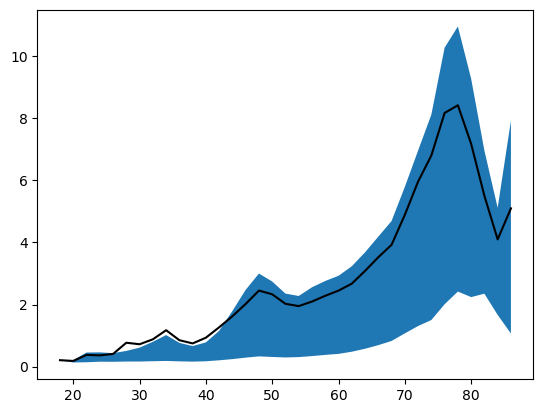

In [6]:
bins = dse_qrt.bins
q25 = dse_qrt.mcs_ocean_25
q75 = dse_qrt.mcs_ocean_75
avg = ds.sel(source='obs').mcs_ocean
plt.fill_between(bins, q25, q75)
plt.plot(bins, avg, color='k')

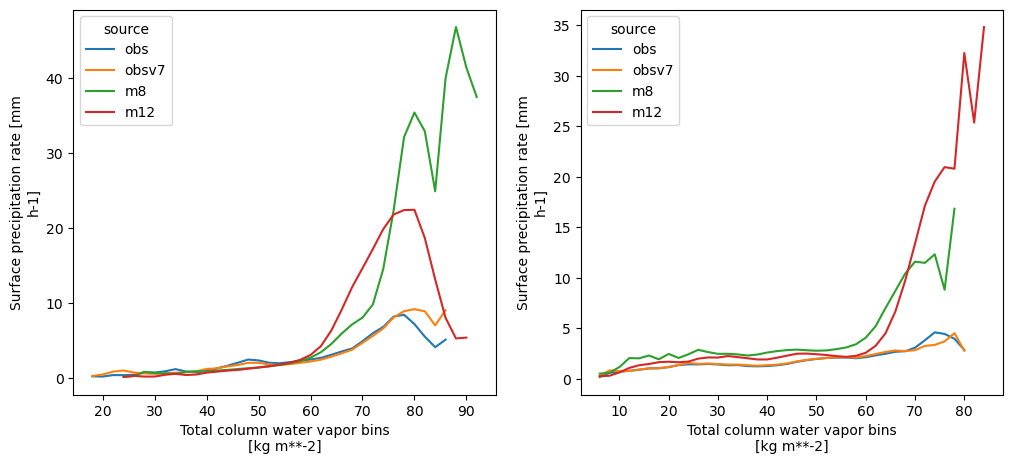

In [7]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
ds.mcs_ocean.plot.line(x='bins', ax=axes[0])
ds.mcs_land.plot.line(x='bins', ax=axes[1])

In [8]:
# Min pdf threshold
min_pdf_thresh = 1e-4
# min_pdf_thresh = 0.5e-5

# Min number of sample threshold
min_ns_thresh = 10

In [9]:
# # Normalize the number of samples in each bin by the total sample
# mcs_ocean_ns = ds.mcs_ocean_ns
# # total_ocean_ns = ds.total_ocean_ns
# mcs_ocean_pdf = mcs_ocean_ns / mcs_ocean_ns.sum(dim='bins')
# # total_ocean_pdf = total_ocean_ns / total_ocean_ns.sum(dim='bins')

# # Filter bins with insufficient samples
# mcs_ocean = ds.mcs_ocean.where(mcs_ocean_pdf > min_pdf_thresh)
# # total_ocean = ds.total_ocean.where(total_ocean_pdf > min_pdf_thresh)

# # Normalize the number of samples in each bin by the total sample
# mcs_land_ns = ds.mcs_land_ns
# # total_land_ns = ds.total_land_ns
# mcs_land_pdf = mcs_land_ns / mcs_land_ns.sum(dim='bins')
# # total_land_pdf = total_land_ns / total_land_ns.sum(dim='bins')

# # Filter bins with insufficient samples
# mcs_land = ds.mcs_land.where(mcs_land_pdf > min_pdf_thresh)
# # total_land = ds.total_land.where(total_land_pdf > min_pdf_thresh)

# # Filter interquartile value bins with insufficient samples
# mcs_ocean25 = dse_qrt.mcs_ocean_25.where(mcs_ocean_pdf.sel(source='obs') > min_pdf_thresh)
# mcs_ocean75 = dse_qrt.mcs_ocean_75.where(mcs_ocean_pdf.sel(source='obs') > min_pdf_thresh)
# mcs_ocean90 = dse_qrt.mcs_ocean_90.where(mcs_ocean_pdf.sel(source='obs') > min_pdf_thresh)
# mcs_land25 = dse_qrt.mcs_land_25.where(mcs_land_pdf.sel(source='obs') > min_pdf_thresh)
# mcs_land75 = dse_qrt.mcs_land_75.where(mcs_land_pdf.sel(source='obs') > min_pdf_thresh)
# mcs_land90 = dse_qrt.mcs_land_90.where(mcs_land_pdf.sel(source='obs') > min_pdf_thresh)

In [10]:
# Normalize the number of samples in each bin by the total sample
mcs_ocean_ns = ds.mcs_ocean_ns
# total_ocean_ns = ds.total_ocean_ns
mcs_ocean_pdf = mcs_ocean_ns / mcs_ocean_ns.sum(dim='bins')
# total_ocean_pdf = total_ocean_ns / total_ocean_ns.sum(dim='bins')

# Filter bins with insufficient samples
mcs_ocean = ds.mcs_ocean.where(mcs_ocean_ns > min_ns_thresh)

# Normalize the number of samples in each bin by the total sample
mcs_land_ns = ds.mcs_land_ns
# total_land_ns = ds.total_land_ns
mcs_land_pdf = mcs_land_ns / mcs_land_ns.sum(dim='bins')
# total_land_pdf = total_land_ns / total_land_ns.sum(dim='bins')

# Filter bins with insufficient samples
mcs_land = ds.mcs_land.where(mcs_land_ns > min_ns_thresh)

# Filter interquartile value bins with insufficient samples
mcs_ocean25 = dse_qrt.mcs_ocean_25.where(mcs_ocean_ns.sel(source='obs') > min_ns_thresh)
mcs_ocean75 = dse_qrt.mcs_ocean_75.where(mcs_ocean_ns.sel(source='obs') > min_ns_thresh)
mcs_ocean90 = dse_qrt.mcs_ocean_90.where(mcs_ocean_ns.sel(source='obs') > min_ns_thresh)
mcs_land25 = dse_qrt.mcs_land_25.where(mcs_land_ns.sel(source='obs') > min_ns_thresh)
mcs_land75 = dse_qrt.mcs_land_75.where(mcs_land_ns.sel(source='obs') > min_ns_thresh)
mcs_land90 = dse_qrt.mcs_land_90.where(mcs_land_ns.sel(source='obs') > min_ns_thresh)

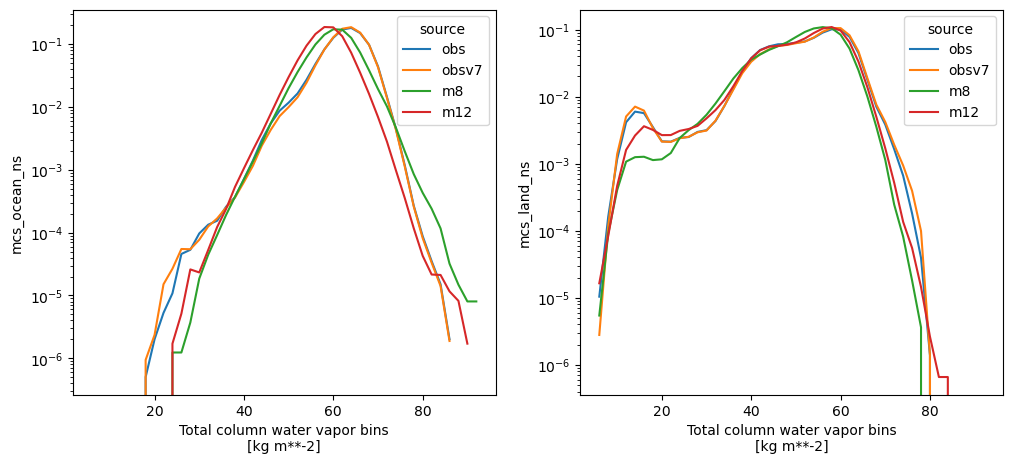

In [11]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_pdf.plot.line(x='bins', ax=axes[0])
mcs_land_pdf.plot.line(x='bins', ax=axes[1])
axes[0].set_yscale('log')
axes[1].set_yscale('log')

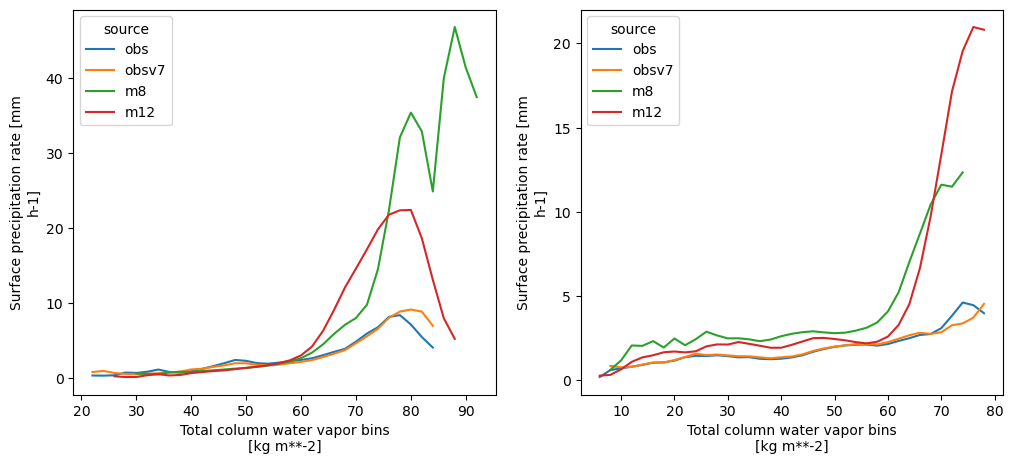

In [12]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean.plot.line(x='bins', ax=axes[0])
mcs_land.plot.line(x='bins', ax=axes[1])

In [13]:
# fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
# total_ocean.plot.line(x='bins', ax=axes[0])
# total_land.plot.line(x='bins', ax=axes[1])

## Function to plot PWV vs. Precipitation

In [14]:
def plot_lines_mxn(nrow, ncol, data_arr, xbin, qrt_arr,
                 titles=None, titles_loc=None, title_ha=None, xlabels=None, ylabels=None, xticks=None, legends=None, legend_loc=None, legend_ncol=None,
                 fontsize=None, legend_fontsize=None, legend_anchor=None, xlims=None, ylims=None, yscale=None, col_labels=None, wspace=None, hspace=None,
                 shade_dict=None, shade_qrt=None, draw_arrow=False, text_dict=None, figname=None, figsize=None, inset_flag=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=wspace, hspace=hspace)
    
    lcolors = {
        'obs': 'k', 
        'obsv7': 'gray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        # 'm12': 'dodgerblue',
        'm12': 'red',
    }
    lw = 2
    lws = {
        'obs': lw*4, 
        'obsv7': lw*2,
        'm1': lw,
        'm2': lw, 
        'm3': lw,
        'm4': lw,
        'm5': lw,
        'm6': lw,
        'm7': lw,
        'm8': lw,
        'm9': lw,
        'm10': lw,
        'm11': lw,
        'm12': lw,
    }
    
    # Loop over column and row
    for col in range(0, ncol):
        for row in range(0, nrow):
            ax = plt.subplot(gs[row,col])
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            if row == 0:
                ax.text(xmid, 1.05, col_labels[col], fontsize=fontsize*1.5, fontweight='bold', ha='center', transform=ax.transAxes)

            # # Share x-axis for all rows in each column
            # if row < nrow - 1:
            #     # ax.get_xaxis().set_visible(False)
            #     ax.set_xticklabels([])
            # else:
            #     ax.set_xlabel(xlabels[col])
            
            # Plot data
            # Shade interquartile range
            if shade_qrt == True:
                iqrt = qrt_arr[row][col]
                if iqrt is not None:
                    ax.fill_between(xbin, iqrt[0], iqrt[1], facecolor='darkgray', alpha=0.5)
                    
            # for key, val in data_arr[row][col].items():
            for key in data_arr[row][col].source.data:
                idata = data_arr[row][col].sel(source=key)
                ax.plot(xbin, idata, lcolors[key], lw=lws[key], label=legends[key])
                
            ax.axvline(x=0, lw=1, ls='--', color='k')
            ax.grid(which='major', ls='--', lw=0.5)
            if (row == nrow - 1): ax.set_xlabel(xlabels[col])
            if ylabels is not None: ax.set_ylabel(ylabels[row][col])
            if xticks is not None: ax.set_xticks(xticks[col])
            if ylims is not None: ax.set_ylim(ylims[row][col][0], ylims[row][col][1])
            if xlims is not None: ax.set_xlim(xlims[col][0], xlims[col][1])
            if yscale is not None: ax.set_yscale(yscale[row][col])
            # ax.set_title(titles[row][col], loc='left')
            # Make title within the axis
            flabel = ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
            flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
            if (row == 0) & (col == ncol-1):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc, ncol=legend_ncol, bbox_to_anchor=legend_anchor)
                # ax.legend(fontsize=legend_fontsize, loc=legend_loc[col], ncol=legend_ncol[col])
            # Fill background color
            if shade_dict:
                # xmin, xmax = ax.get_xlim()
                ax.axvspan(shade_dict['xmin'], shade_dict['xmax'], facecolor=shade_dict['color'], alpha=shade_dict['alpha'], transform=ax.get_xaxis_transform())
                # ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
                
            # Draw an arrow to show the direction of time increase
            if (draw_arrow) & (row == nrow-1):
                ax.annotate('', xy=(1, -0.3), xytext=(0, -0.3), xycoords='axes fraction',
                            arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))
    # Add text to figure
    if text_dict is not None:
        fig.text(text_dict['x'], text_dict['y'], text_dict['text'], ha=text_dict['ha'], va=text_dict['va'], fontsize=text_dict['fontsize'])

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

In [15]:
if PHASE == 'Summer':
    titles = [
        ['(a) Ocean Precipitation (Summer)', '(b) Land Precipitation (Summer)',],
        ['(c) Ocean PW (Summer)', '(d) Land PW (Summer)',],
    ]
elif PHASE == 'Winter':
    titles = [
        ['(e) Ocean Precipitation (Winter)', '(f) Land Precipitation (Winter)',],
        ['(g) Ocean PW (Winter)', '(h) Land PW (Winter)',],
    ]
print(titles)

[['(e) Ocean Precipitation (Winter)', '(f) Land Precipitation (Winter)'], ['(g) Ocean PW (Winter)', '(h) Land PW (Winter)']]


/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/SCREAM/mcs_pwv_collocated_ocean_land_PyFLEXTRKR.png


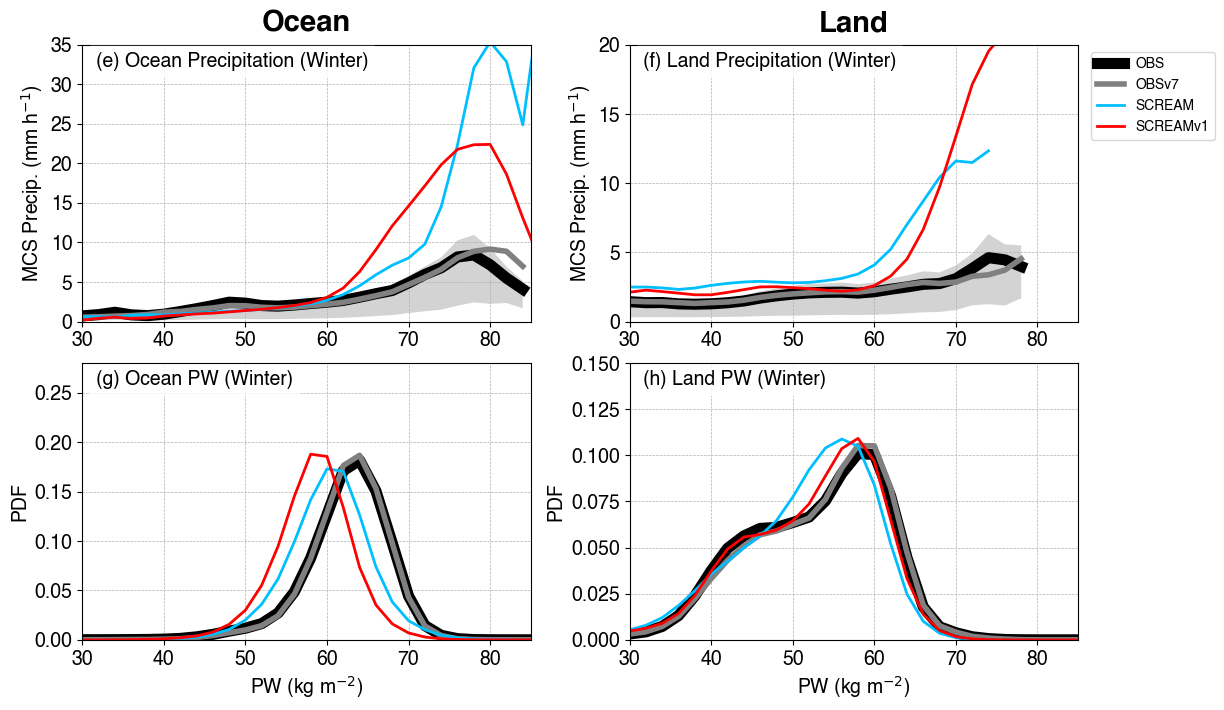

In [16]:
# Data array [row][col]
data_arr = [
    [mcs_ocean, mcs_land],
    [mcs_ocean_pdf, mcs_land_pdf],
]
qrt_arr = [
    [(mcs_ocean25, mcs_ocean75), (mcs_land25, mcs_land75)],
    # [(mcs_ocean25, mcs_ocean90), (mcs_land25, mcs_land90)],
    [None, None],
]
xbin = mcs_ocean.bins
legends = name_map
nrow = len(data_arr)
ncol = 2
col_labels = ['Ocean', 'Land']
titles_loc = [0.03, 0.92]
title_ha = 'left'
xlabels = ['PW (kg m$^{-2}$)','PW (kg m$^{-2}$)']
ylabels = [['MCS Precip. (mm h$^{-1}$)', 'MCS Precip. (mm h$^{-1}$)'],['PDF', 'PDF']]
xticks = None
xlims = [(30,85),(30,85)]
ylims = [[(0,35),(0,20)],[(0,0.28),(0,0.15)]]
# ylims = [[(1e-3,100),(1e-2,100)],[(0,0.22),(0,0.13)]]
yscale = [['linear','linear'],['linear','linear']]

legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.32, 1)
fontsize = 14
legend_fontsize = 10
figsize = [12,7]
wspace = 0.22
hspace = 0.15
# text_dict = {'text': f'{diameter_km:.0f}km', 'x': 1.0, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.5}
text_dict = None
# shade_dict = {'xmin':60, 'xmax':70, 'color':'lightskyblue', 'alpha':0.2}
shade_dict = None
figname = f'{figdir}mcs_pwv_collocated_ocean_land_{tracker}.png'
print(figname)
fig = plot_lines_mxn(nrow, ncol, data_arr, xbin, qrt_arr,
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, yscale=yscale, col_labels=col_labels, wspace=wspace, hspace=hspace,
                   shade_dict=shade_dict, shade_qrt=True, draw_arrow=False, text_dict=text_dict, figname=figname, figsize=figsize)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/SCREAM/mcs_pwv_collocated_ocean_land_PyFLEXTRKR_ylog.png


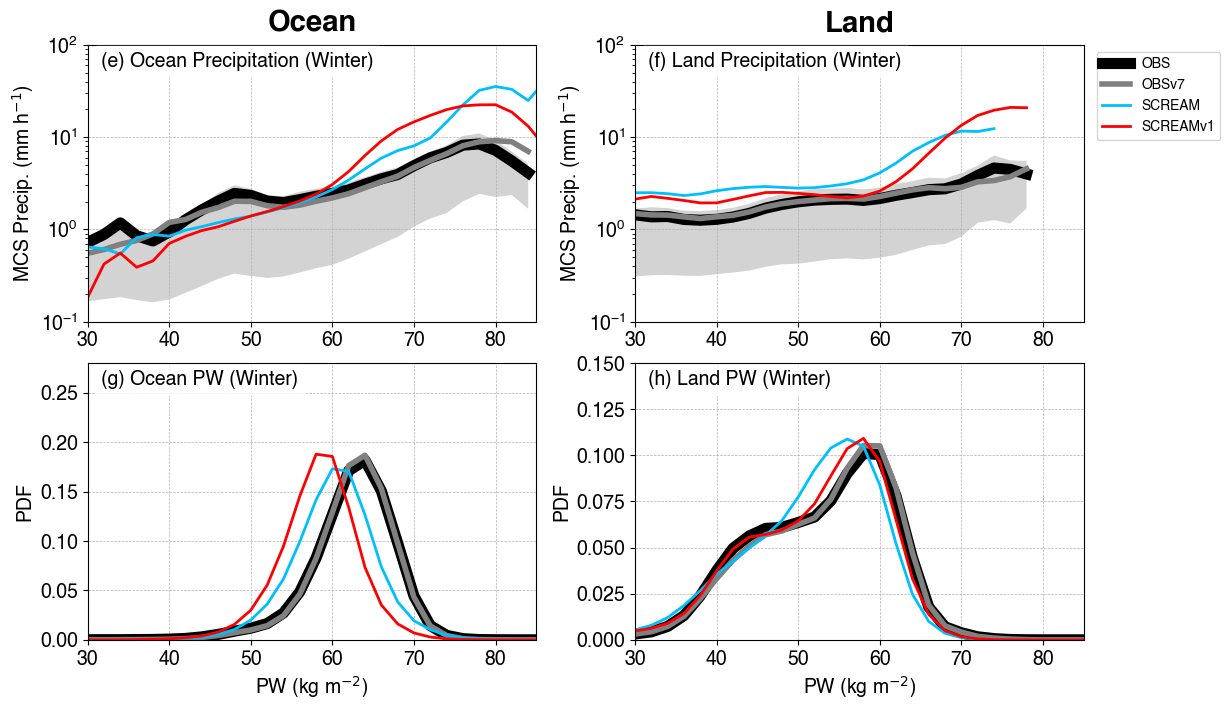

In [17]:
# Data array [row][col]
data_arr = [
    [mcs_ocean, mcs_land],
    [mcs_ocean_pdf, mcs_land_pdf],
]
qrt_arr = [
    [(mcs_ocean25, mcs_ocean75), (mcs_land25, mcs_land75)],
    [None, None],
]
xbin = mcs_ocean.bins
legends = name_map
nrow = len(data_arr)
ncol = 2
col_labels = ['Ocean', 'Land']
titles_loc = [0.03, 0.92]
title_ha = 'left'
xlabels = ['PW (kg m$^{-2}$)','PW (kg m$^{-2}$)']
ylabels = [['MCS Precip. (mm h$^{-1}$)', 'MCS Precip. (mm h$^{-1}$)'],['PDF', 'PDF']]
xticks = None
xlims = [(30,85),(30,85)]
# ylims = [[(0,33),(0,33)],[(0,0.22),(0,0.13)]]
ylims = [[(1e-1,100),(1e-1,100)],[(0,0.28),(0,0.15)]]
yscale = [['log','log'],['linear','linear']]

legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.32, 1)
fontsize = 14
legend_fontsize = 10
figsize = [12,7]
wspace = 0.22
hspace = 0.15
text_dict = None
shade_dict = None
figname = f'{figdir}mcs_pwv_collocated_ocean_land_{tracker}_ylog.png'
print(figname)
fig = plot_lines_mxn(nrow, ncol, data_arr, xbin, qrt_arr,
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, yscale=yscale, col_labels=col_labels, wspace=wspace, hspace=hspace,
                   shade_dict=shade_dict, shade_qrt=True, draw_arrow=False, text_dict=text_dict, figname=figname, figsize=figsize)

## The next section shifts the model PW PDF and precipitation to match the model PW PDF with observations

In [18]:
# Define the Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

In [19]:
def find_peak_value(bin_centers, histogram_values):
    # Find valid value indices 
    idx_valid = ~np.isnan(histogram_values)
    # Remove NaN
    _hist = histogram_values[idx_valid]
    _bins = bin_centers[idx_valid]

    # Fit the Gaussian function to the histogram data
    popt, pcov = curve_fit(gaussian, _bins, _hist, p0=[np.mean(_bins), np.std(_bins), np.max(_hist)])

    # Extract the parameters
    # mu: location of the peak value (mean of the distribution)
    # sigma: standard deviation
    # A: amplitdue
    mu, sigma, A = popt

    return mu, sigma, A

In [20]:
mu, sigma, A = find_peak_value(xbin, mcs_ocean_pdf.sel(source='obs').values)
mu, sigma, A

(63.23048411161775, 4.26221919540361, 0.18014046410865836)

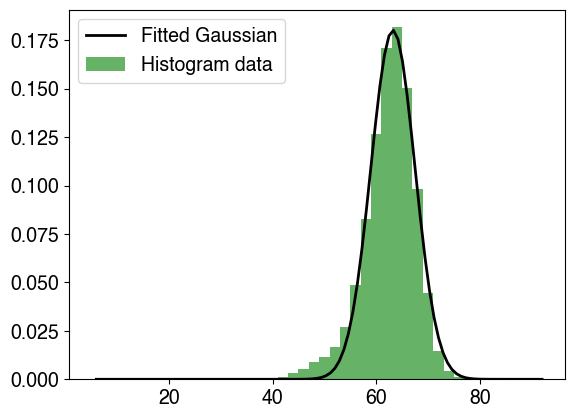

In [21]:
# Plot the histogram and the fitted Gaussian function
plt.bar(xbin, mcs_ocean_pdf.sel(source='obs'), width=(xbin[1] - xbin[0]), alpha=0.6, color='g', label='Histogram data')
x = np.linspace(min(xbin), max(xbin), 100)
plt.plot(x, gaussian(x, mu, sigma, A), 'k', linewidth=2, label='Fitted Gaussian')
plt.legend()

## Fit Gaussian to PDFs and find peak values

In [22]:
peak_pw_ocean = np.full(len(name_map), np.NaN, dtype=float)
peak_pw_land = np.full(len(name_map), np.NaN, dtype=float)

# Loop over each source
for isrc in range(len(name_map)):
    # Fit Gaussian to find peak value (ocean)
    mu, sigma, A = find_peak_value(xbin, mcs_ocean_pdf.isel(source=isrc).values)
    peak_pw_ocean[isrc] = mu
    # Fit Gaussian to find peak value (land)
    mu, sigma, A = find_peak_value(xbin, mcs_land_pdf.isel(source=isrc).values)
    peak_pw_land[isrc] = mu

# Convert to DataArray
peak_pw_ocean = xr.DataArray(peak_pw_ocean, coords={'source':list(name_map.keys())}, dims=('source'))
peak_pw_land = xr.DataArray(peak_pw_land, coords={'source':list(name_map.keys())}, dims=('source'))

# Calculate peak PW differences between models and obs to get the shifts
pw_shifts_ocean = (peak_pw_ocean.sel(source='obs') - peak_pw_ocean).drop_sel(source=('obsv7','obs'))
pw_shifts_land = (peak_pw_land.sel(source='obs') - peak_pw_land).drop_sel(source=('obsv7','obs'))

In [23]:
pw_shifts_ocean, pw_shifts_land

(<xarray.DataArray (source: 2)>
 array([2.76550058, 4.60248177])
 Coordinates:
   * source   (source) <U5 'm8' 'm12',
 <xarray.DataArray (source: 2)>
 array([0.5451359 , 0.12591026])
 Coordinates:
   * source   (source) <U5 'm8' 'm12')

## Make PW bins with the shift for each model

In [24]:
xbin_shift_ocean = {}
xbin_shift_ocean['obs'] = xbin.values
xbin_shift_ocean['obsv7'] = xbin.values
for isrc in range(len(pw_shifts_ocean)):
    # print(isrc, pw_shifts_ocean.isel(source=isrc).source.item())
    key = pw_shifts_ocean.isel(source=isrc).source.item()
    xbin_shift_ocean[key] = xbin.values + pw_shifts_ocean.isel(source=isrc).values

xbin_shift_land = {}
xbin_shift_land['obs'] = xbin.values
xbin_shift_land['obsv7'] = xbin.values
for isrc in range(len(pw_shifts_land)):
    # print(isrc, pw_shifts_land.isel(source=isrc).source.item())
    key = pw_shifts_land.isel(source=isrc).source.item()
    xbin_shift_land[key] = xbin.values + pw_shifts_land.isel(source=isrc).values

In [25]:
# xbin_shift_ocean

In [26]:
# plt.plot(xbin, mcs_ocean_pdf.sel(source='obs'), color='k')
# plt.plot(xbin_shift_ocean['m12'], mcs_ocean_pdf.sel(source='m12'))

## Function to plot shifted PWV vs. Precipitation

In [32]:
def plot_lines_mxn2(nrow, ncol, data_arr, xbin, qrt_arr,
                 titles=None, titles_loc=None, title_ha=None, xlabels=None, ylabels=None, xticks=None, legends=None, legend_loc=None, legend_ncol=None,
                 fontsize=None, legend_fontsize=None, legend_anchor=None, xlims=None, ylims=None, yscale=None, col_labels=None, wspace=None, hspace=None,
                 shade_dict=None, shade_qrt=None, draw_arrow=False, text_dict=None, figname=None, figsize=None, inset_flag=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=wspace, hspace=hspace)
    
    lcolors = {
        'obs': 'k', 
        'obsv7': 'gray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        # 'm12': 'dodgerblue',
        'm12': 'red',
    }
    lw = 2
    lws = {
        'obs': lw*4, 
        'obsv7': lw*2,
        'm1': lw,
        'm2': lw, 
        'm3': lw,
        'm4': lw,
        'm5': lw,
        'm6': lw,
        'm7': lw,
        'm8': lw,
        'm9': lw,
        'm10': lw,
        'm11': lw,
        'm12': lw,
    }
    
    # Loop over column and row
    for col in range(0, ncol):
        for row in range(0, nrow):
            ax = plt.subplot(gs[row,col])
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            if row == 0:
                ax.text(xmid, 1.05, col_labels[col], fontsize=fontsize*1.5, fontweight='bold', ha='center', transform=ax.transAxes)

            # # Share x-axis for all rows in each column
            # if row < nrow - 1:
            #     # ax.get_xaxis().set_visible(False)
            #     ax.set_xticklabels([])
            # else:
            #     ax.set_xlabel(xlabels[col])
            
            # Plot data
            # Shade interquartile range
            if shade_qrt == True:
                iqrt = qrt_arr[row][col]
                if iqrt is not None:
                    ax.fill_between(xbin[col]['obs'], iqrt[0], iqrt[1], facecolor='darkgray', alpha=0.5)
                    
            # for key, val in data_arr[row][col].items():
            for key in data_arr[row][col].source.data:
                idata = data_arr[row][col].sel(source=key)
                ibin = xbin[col][key]
                ax.plot(ibin, idata, lcolors[key], lw=lws[key], label=legends[key])
                
            ax.axvline(x=0, lw=1, ls='--', color='k')
            ax.grid(which='major', ls='--', lw=0.5)
            if (row == nrow - 1): ax.set_xlabel(xlabels[col])
            if ylabels is not None: ax.set_ylabel(ylabels[row][col])
            if xticks is not None: ax.set_xticks(xticks[col])
            if ylims is not None: ax.set_ylim(ylims[row][col][0], ylims[row][col][1])
            if xlims is not None: ax.set_xlim(xlims[col][0], xlims[col][1])
            if yscale is not None: ax.set_yscale(yscale[row][col])
            # ax.set_title(titles[row][col], loc='left')
            # Make title within the axis
            flabel = ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
            flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
            if (row == 0) & (col == ncol-1):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc, ncol=legend_ncol, bbox_to_anchor=legend_anchor)
                # ax.legend(fontsize=legend_fontsize, loc=legend_loc[col], ncol=legend_ncol[col])
            # Fill background color
            if shade_dict:
                # xmin, xmax = ax.get_xlim()
                ax.axvspan(shade_dict['xmin'], shade_dict['xmax'], facecolor=shade_dict['color'], alpha=shade_dict['alpha'], transform=ax.get_xaxis_transform())
                # ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
                
            # Draw an arrow to show the direction of time increase
            if (draw_arrow) & (row == nrow-1):
                ax.annotate('', xy=(1, -0.3), xytext=(0, -0.3), xycoords='axes fraction',
                            arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))
    # Add text to figure
    if text_dict is not None:
        fig.text(text_dict['x'], text_dict['y'], text_dict['text'], ha=text_dict['ha'], va=text_dict['va'], fontsize=text_dict['fontsize'])

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

In [33]:
# xbin_noshift = {}
# for key, val in name_map.items():
#     xbin_noshift[key] = xbin.values

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/SCREAM/mcs_pwv_collocated_ocean_land_PyFLEXTRKR_PWscale.png


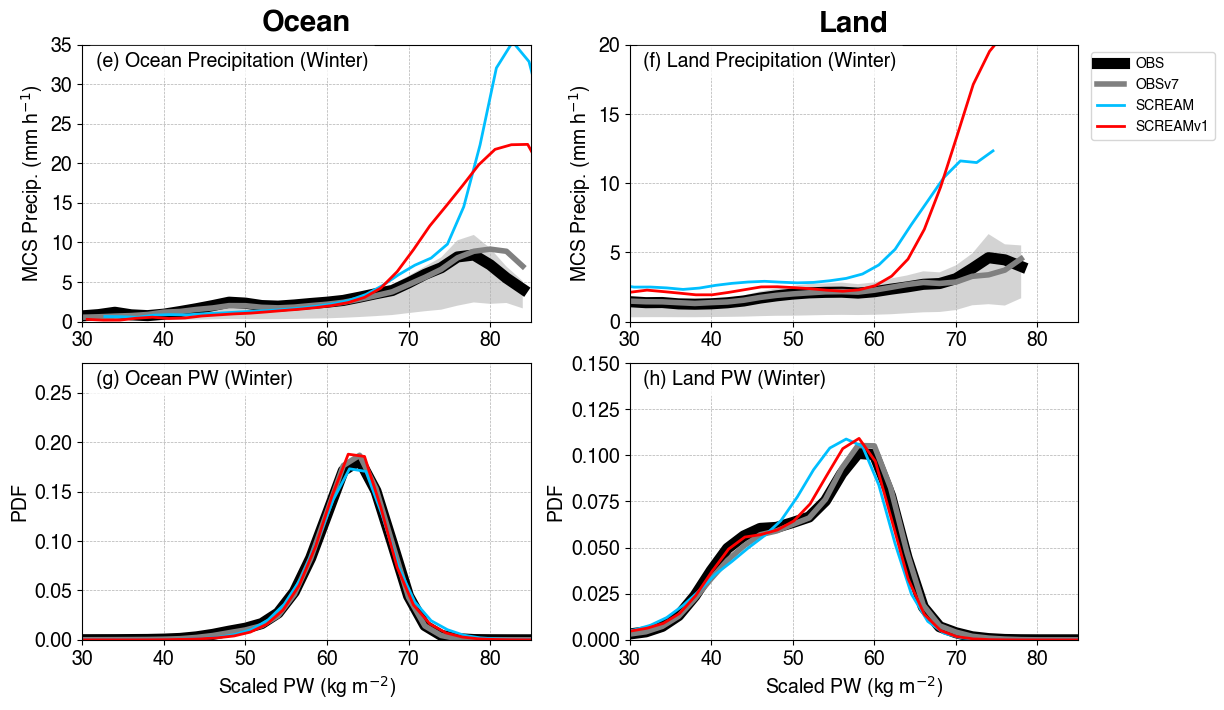

In [34]:
# Data array [row][col]
data_arr = [
    [mcs_ocean, mcs_land],
    [mcs_ocean_pdf, mcs_land_pdf],
]
qrt_arr = [
    [(mcs_ocean25, mcs_ocean75), (mcs_land25, mcs_land75)],
    [None, None],
]
_xbin = [xbin_shift_ocean, xbin_shift_land]
legends = name_map
nrow = len(data_arr)
ncol = 2
col_labels = ['Ocean', 'Land']
titles_loc = [0.03, 0.92]
title_ha = 'left'
xlabels = ['Scaled PW (kg m$^{-2}$)','Scaled PW (kg m$^{-2}$)']
ylabels = [['MCS Precip. (mm h$^{-1}$)', 'MCS Precip. (mm h$^{-1}$)'],['PDF', 'PDF']]
xticks = None
xlims = [(30,85),(30,85)]
ylims = [[(0,35),(0,20)],[(0,0.28),(0,0.15)]]
# ylims = [[(1e-3,100),(1e-2,100)],[(0,0.22),(0,0.13)]]
yscale = [['linear','linear'],['linear','linear']]

legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.32, 1)
fontsize = 14
legend_fontsize = 10
figsize = [12,7]
wspace = 0.22
hspace = 0.15
text_dict = None
shade_dict = None
figname = f'{figdir}mcs_pwv_collocated_ocean_land_{tracker}_PWscale.png'
print(figname)
fig = plot_lines_mxn2(nrow, ncol, data_arr, _xbin, qrt_arr,
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels, wspace=wspace, hspace=hspace,
                   shade_dict=shade_dict, shade_qrt=True, draw_arrow=False, text_dict=text_dict, figname=figname, figsize=figsize)

In [35]:
# if PHASE == 'Summer':
#     titles = [
#         ['(a) Ocean Precipitation (Summer)'],
#         ['(c) Ocean PW (Summer)'],
#     ]
# elif PHASE == 'Winter':
#     titles = [
#         ['(b) Ocean Precipitation (Winter)',],
#         ['(d) Ocean PW (Winter)',],
#     ]

# # Data array [row][col]
# data_arr = [
#     [mcs_ocean, ],
#     [mcs_ocean_pdf, ],
# ]
# qrt_arr = [
#     [(mcs_ocean25, mcs_ocean75), ],
#     [None, ],
# ]
# _xbin = [xbin_shift_ocean, ]
# legends = name_map
# nrow = len(data_arr)
# ncol = 1
# col_labels = [PHASE]
# titles_loc = [0.03, 0.92]
# title_ha = 'left'
# xlabels = ['Scaled PW (kg m$^{-2}$)','Scaled PW (kg m$^{-2}$)']
# ylabels = [['MCS Precip. (mm h$^{-1}$)', 'MCS Precip. (mm h$^{-1}$)'],['PDF', 'PDF']]
# xticks = None
# xlims = [(30,85),(30,85)]
# ylims = [[(0,33),(0,33)],[(0,0.22),(0,0.13)]]
# # ylims = [[(1e-3,100),(1e-2,100)],[(0,0.22),(0,0.13)]]
# yscale = [['linear','linear'],['linear','linear']]

# legend_loc = 'upper right'
# legend_ncol = 1
# legend_anchor = (1.3, 1)
# fontsize = 14
# legend_fontsize = 10
# figsize = [6,8]
# wspace = 0.22
# hspace = 0.15
# text_dict = None
# shade_dict = None
# figname = f'{figdir}mcs_pwv_collocated_ocean_{tracker}_PWscale.png'
# print(figname)
# fig = plot_lines_mxn2(nrow, ncol, data_arr, _xbin, qrt_arr,
#                    titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
#                    fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, yscale=yscale, col_labels=col_labels, wspace=wspace, hspace=hspace,
#                    shade_dict=shade_dict, shade_qrt=True, draw_arrow=False, text_dict=text_dict, figname=figname, figsize=figsize)

In [36]:
# if PHASE == 'Summer':
#     titles = [
#         ['(a) Ocean Precipitation (Summer)'],
#         ['(c) Ocean PW (Summer)'],
#     ]
# elif PHASE == 'Winter':
#     titles = [
#         ['(b) Ocean Precipitation (Winter)',],
#         ['(d) Ocean PW (Winter)',],
#     ]

# # Data array [row][col]
# data_arr = [
#     [mcs_ocean, ],
#     [mcs_ocean_pdf, ],
# ]
# qrt_arr = [
#     [(mcs_ocean25, mcs_ocean75), ],
#     [None, ],
# ]
# _xbin = [xbin_shift_ocean, ]
# legends = name_map
# nrow = len(data_arr)
# ncol = 1
# col_labels = [PHASE]
# titles_loc = [0.03, 0.92]
# title_ha = 'left'
# xlabels = ['Scaled PW (kg m$^{-2}$)','Scaled PW (kg m$^{-2}$)']
# ylabels = [['MCS Precip. (mm h$^{-1}$)', 'MCS Precip. (mm h$^{-1}$)'],['PDF', 'PDF']]
# xticks = None
# xlims = [(30,85),(30,85)]
# # ylims = [[(0,33),(0,33)],[(0,0.22),(0,0.13)]]
# ylims = [[(1e-3,100),(1e-2,100)],[(0,0.22),(0,0.13)]]
# yscale = [['log','log'],['linear','linear']]

# legend_loc = 'upper right'
# legend_ncol = 1
# legend_anchor = (1.3, 1)
# fontsize = 14
# legend_fontsize = 10
# figsize = [6,8]
# wspace = 0.22
# hspace = 0.15
# text_dict = None
# shade_dict = None
# figname = f'{figdir}mcs_pwv_collocated_ocean_{tracker}_PWscale_ylog.png'
# print(figname)
# fig = plot_lines_mxn2(nrow, ncol, data_arr, _xbin, qrt_arr,
#                    titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
#                    fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, yscale=yscale, col_labels=col_labels, wspace=wspace, hspace=hspace,
#                    shade_dict=shade_dict, shade_qrt=True, draw_arrow=False, text_dict=text_dict, figname=figname, figsize=figsize)